# Introduction to machine learning

 * Supervised learning
   * scikit-learn
   * Patent assignee forms
   * Features
   * Training and test data
   * k Nearest neighbors
   * Naive Bayes
 * Unsupervised learning
   * Political polarization
   * k Means
   * Hierarchical clustering
 * Further reading
 * Exercises

> MONSIEUR JOURDAIN: Oh, really? So when I say: Nicole bring me my slippers and fetch my nightcap,” is that prose?
> 
> PHILOSOPHY MASTER: Most clearly.
> 
> MONSIEUR JOURDAIN: Well, what do you know about that! These forty years now I’ve been speaking in prose without knowing it!
> 
> —Molière, The Bourgeois Gentleman, 1670

It's hard to think of an area of scientifc research in recent memory that has received more attention (both public and academic) than machine learning. Although the basic principles of machine learning have been around for a long time, a confluence of several factors, including advances in computing power, data availability (necessary for training high-performing models), algorithms, and the commercial potential of the technology have led to significant excitement within the field (Jordan and Mitchell, 2015). 

The primary beneficiary of machine learning has arguably been industry, with uptake being slower in science, although that's starting to change. As I hope you'll see by the end of this session, machine learning has potential applications for all phases of the research process, from data collection and cleaning to modeling and analysis.

Machine learning is not a mainstay of the social science PhD curriculum, which means that social scientists who are curious about machine learning typically need to resort to self study. Given just how vast machine learning has become, together with the fairly jargon-heavy nature of the field, its easy for people to feel overwhelmed before they even really get started. As we know from all sorts of research (Cohen and Levinthal, 1990), learning about a new field is really tricky when we're starting from scratch, without some prior knowledge on which to build.

What if I told you, though, that every time you run a regression model you're doing machine learning? It's true! Just like Monsieur Jourdain was speaking prose for forty years without knowing it, you already likely have some familiarity with a major area of machine learning.

This notebook will be primarily organized around the two main branches of machine learning, supervised and unsupervised learning (the former of which includes regression). Without further ado, then, let's get started!

# scikit-learn

As a heads up, throughout this session, we'll be making heavy use of the Python package [scikit-learn](https://scikit-learn.org), which is probably the most popular machine learning library for Python. You don't need to know much more than that at this point. 

# Supervised learning

There are two general approaches to machine learning, supervised and unsupervised. Supervised learning involves building models for prediction or labeling tasks. For example, we might want to build a model to label whether a product review is positive or negative, whether a consumer would like a product or not, or whether an image includes a picture of a cat. The name "supervised" comes from the fact that when we build these models, we use training data, i.e., a set of examples where the outcome or label is known. We might build a model by collecting 10,000 images, creating a dummy varaible that identifies those with cats, and then training our model to identify which features (or variables) are most strongly predictive of the presence of a cat. So we are "supervising" in the sense that we are specifying particular relationships we want the model to learn (between a dependent and independent variables, or labels and features, from our training data).

Within supervised learning, we can distinguish models depending on whether the outcome of interest is categorical or continuous. The former, which we refer to as classification, would include cases where we want to develop a model that will determine, based on a set of observed features or variables, whether an observation is a member of a particular class (e.g., whether a review is positive based on the words it contains). The latter, which we refer to as regression, would include cases where we want to develop a model that will determine, again based on a set of observed features or variables, the predicted value for an observation on a continuous measure (e.g., the mpg for a car based on its weight, age, make, model, and other factors).

## Patent assignee forms

To help ground our exploration of supervised machine learning, let's consider a concrete example, once again using data from the U.S. Patent and Trademark Office. Patents are a form of intellectual property. When a patent is granted by the USPTO, the property rights are given to an assignee, which is often different from the inventor(s) and most typically consists of a legal organization (e.g., a business). Historically, most patents have been granted to business firms, but over the past few decades, a much broader range of organizations, from universities and nonprofits to government labs, have been seeking intellectual property protection for their discoveries. 

Suppose we wanted to gain some sense for how the representation of different kinds or forms of organizatons (e.g., universities, firms) among patent assignees has changed over time. It turns out that doing so is a bit of a challenge for a few reasons. First, the USPTO only began collecting data on assignee form after 2002, and the categories recorded are somewhat broad and do not necessarily correspond to those that might be most interesting from a theoretical standpoint (e.g., the categories mainly distinguish between US and foreign individuals, corporations, and governments). Second, the only data that the USPTO reliably reports on assignees over time is assignee name and location, which makes it difficult to link assignees to external databases that might give us insight on organizational forms. Moreover, even if we could easily link to external databases (e.g., Compustat), I am unaware of anything that would cover the whole range of diverse organizational forms represented among assignees (e.g., large and small corporations, universities, governments, research institutes). 

One option for us might be to leverage the fact that different kinds of organizational forms tend to exhibit different kinds of naming patterns. Most universities, for example, include the word "university" in their name, but not the word "corporation." The names of consulting and professional service firms tend to include words like "associates," "services," "solutions," and "consulting." If we went through the whole list of USPTO assignees, we might then be able to categorize them into broad organizational forms with some reasonable level of accuracy. 

The challenge, though, is that there are hundreds of thousands of organizations that have been assigned a US patent, which prohibits us from doing this coding manually. Moreover, even though we might be able to come up with a mechanical set of rules (e.g., if the name contains "university" code as "university"), we would likely only be able to develop a handful of rules, and those that we would develop would not likely apply to all situations. For example, our "university" rule would code the name "University Park Semiconductor Corporation" incorrectly as a university.

This is where we can get some help from supervised learning methods.

But before we get started, let's do a little preparation. Our first step will be to download assignee data from the USPTO Patents View website. 

In [2]:
# load packages
import pathlib
import urllib
import pandas as pd

# make a directory to store the data
pathlib.Path("data").mkdir(parents=True, exist_ok=True)

# download the data
patentsview_assignee_file_url = "http://s3.amazonaws.com/data.patentsview.org/20191231/download/assignee.tsv.zip"
patentsview_assignee_file_path = "data/assignee.tsv.zip"
filename, headers = urllib.request.urlretrieve(patentsview_assignee_file_url, patentsview_assignee_file_path)

Next, let's read the data into a pandas dataframe and do a little clean up.

In [3]:
# read file into data frame
assignee_df = pd.read_csv(patentsview_assignee_file_path, sep="\t", low_memory=False)
assignee_df = assignee_df.sample(frac=1, random_state=1011)

# drop non-organizations
assignee_df = assignee_df.drop(columns=["type", "name_first", "name_last"])
assignee_df = assignee_df.dropna()

# drop some cases with bad encoding (on patentsview end)
assignee_df = assignee_df[assignee_df["organization"].apply(lambda x: len(x) == len(x.encode()))]

# check out the data
assignee_df.head()

,id,organization
53008,org_6R3BcU4EOukMvhMb9CXq,Tonen Sekiyukagku Kabushiki Kaisha
174229,org_h05oPXQ4hM8b8i1TpVxM,Barco Automation Naamloze and Vennootschap
111778,org_CLvn05ItaQ0jCyi8zcVn,Tim Blakeney's Practical Solutions LLC
9384,org_0MRMNWjXfHSQ0MvrHyQ6,Strategic Technologies International Inc.
111540,org_Cldq5xEZFrApqP8KYLbL,"BIO AG RESOURCES, INC."


At this point, we need some training data. Recall that training data are authoritative examples that we'll use to help our model learn to make predictions (e.g., here, between features of assignee names and different categories of organizational forms). For our purposes, I am going to go ahead and pull a random sample of assignee names, and the subsequently code their form by hand, using a combination of prior personal knowledge (I've spent a lot of time looking at patent assignees) and internet searches.

In [4]:
# create a directory for hand coding training data
pathlib.Path("hand_cleaning").mkdir(parents=True, exist_ok=True)

# add a column for hand coded assignee form
assignee_df["hand_coded_assignee_form"] = None

# pull a random sample of data to hand code and save as a .csv
hand_coded_assignee_form_file_raw_path = "hand_cleaning/hand_coded_assignee_form.csv"
assignee_df[["organization","hand_coded_assignee_form"]].sample(n=2000, random_state=1011).to_csv(hand_coded_assignee_form_file_raw_path, index=False)

Okay, that didn't take quite as long as expected. I ended up coding assignees into several categories, including "financial", "university", "government", "firm", "professional", "nonprofit", and "other". These may be a bit more granular than we can justify given that the only features we have are based on assignee names, and if you were doing this for research purposes you'd likely want to be more careful than I was with the coding. But for our purposes, let's run with it. Our last step then is to load my hand-coded data into a dataframe.

In [5]:
# read file into data frame
hand_coded_assignee_form_file_complete_path = "hand_cleaning/hand_coded_assignee_form_complete.csv"
hand_coded_assignee_form_df = pd.read_csv(hand_coded_assignee_form_file_complete_path, low_memory=False)

# check out the data
hand_coded_assignee_form_df.head()

,organization,hand_coded_assignee_form
0,"Synbank, Inc.",FINANCIAL
1,HSBC Bank USA,FINANCIAL
2,DWBH Ventures Ltd.,FINANCIAL
3,MINERVA PATENTS S.A.,FINANCIAL
4,AZA HOLDING PTE. LTD.,FINANCIAL


## Training and test data

Before we move forward, we'll want to set aside some of our hand coded data for testing purposes. We'll use part of our 2000 or so hand coded observations to train our model, while saving part to evaluate the performance of our model out of sample. 

You may recoil a bit at the idea of not using each and every one of your hard-won training observations to build your model; but in the supervised learning context, it's really important to save some data for testing because otherwise we'll be at a severe risk for unwittingly overfitting our training data. What we want to avoid is building a (likely complex) model that fits our training data very well (and therefore gives us the appearance of high performance) but that is so tailored to the idiosyncracies of our training data that it misses the more meaningful, general patterns that we're likely to see when we apply our model to unlabeled data.

Note that in addition to test data, machine learning practitioners will also often hold out an additional set of observations from the training data, called validation data. This data is used for tuning the hyperparameters, and allows us to keep our test data completely separate from the data we use to build our models. 

So without further ado, let's split our hand coded organizational forms into training and test data sets. Turns out scikit-learn will make this easy for us.

In [6]:
# load some packages
from sklearn.model_selection import train_test_split

In [7]:
# split into training and test
X_assignee_name_train, X_assignee_name_test, y_assignee_name_train, y_assignee_name_test = train_test_split(hand_coded_assignee_form_df["organization"], 
                                                                                                            hand_coded_assignee_form_df["hand_coded_assignee_form"], 
                                                                                                            test_size=0.1, 
                                                                                                            random_state=10101)

Now let's check out our two data sets.

In [8]:
# show sizes
print(X_assignee_name_train.shape)
print(X_assignee_name_test.shape)
print(y_assignee_name_train.shape)
print(y_assignee_name_test.shape)

(1800,)
(200,)
(1800,)
(200,)


## Features

We now have some training and test data. Yay! If we want to draw parallels to territory more familiar to social scientists, what we've essentially done up to this point is build a data set with about 2000 observations and a dependent variable (`hand_coded_assignee_form`), on to which we have tacked a field of more or less raw data (`organization`). What we're missing are some covariates (or right hand side variables) that we can use to predict our dependent variable (or label or class). 

I've already discussed a few of the barriers that can make entry into machine learning a challenge for social scientists. To that list, I would also add that many concepts that would be familiar to social scientists go by different names in the field of machine learning. In particular, note that in machine learning land, what social scientists refer to as independent variables, control variables, or covariates go by the name of features. 

Let's go ahead and construct some features for our data. Recall that for the purposes of our particular example, what we want to do is leverage features of organization names (e.g., the presence of things like "university" or "corporation") to predict the form of the organization. It seems then, that a reasonable set of features would be variables indicating the presence of certain terms in the names of our organization observations. 

Fortunately, `scikit-learn` will make this process really easy for us. Specifically, we'll us the built in [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which will create a dictionary of features (tokens) and then subsequently allow us to transform documents (i.e., our organization names) into feature vectors. 

In [9]:
# load some packages
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
# initialize our CountVectorizer
assignee_name_vectorizer = CountVectorizer(lowercase=True, max_df=1.0, min_df=1, stop_words="english")

# fit the CountVectorizer to the data
X_assignee_name_train_counts = assignee_name_vectorizer.fit_transform(X_assignee_name_train)

That's about all there is to it! Let's take a closer look at what we just made.

In [11]:
# show the shape of our organization name X feature matrix
X_assignee_name_train_counts.shape

(1800, 2897)

In [12]:
# show a few features
assignee_name_vectorizer.get_feature_names()[0:15]

['03',
 '12',
 '13',
 '18',
 '1943596',
 '1984',
 '1990',
 '1spatial',
 '2000',
 '2020',
 '2749394',
 '3degrees',
 '3m',
 '3u',
 '440']

Finally, let's encode our labels as integers.

In [13]:
# load some packages
from sklearn.preprocessing import LabelEncoder

In [14]:
# initialize label encoder
le = LabelEncoder()

# fit LabelEncoder to the data
y_assignee_name_train_codes = le.fit_transform(y_assignee_name_train)

# we can also reverse the encoding later
le.inverse_transform([2, 2, 1])

array(['GOVERNMENT', 'GOVERNMENT', 'FIRM'], dtype=object)

## k Nearest Neighbors

> Tennyson once said that if we could understand a single flower, we should know who we are and what the world is. Perhaps he meant that there is no fact, however insignificant, that does not involve universal history and the infinite concatenation of cause and effect. Perhaps he meant that the visible world is implicit every phenomenon, just as the will, according to Schopenhauer, is implicit in every subject. —Jorge Luis Borges, The Zahir

Given all the hype around machine learning today, you're probably itching to learn more about the latest and greatest techniques, like deep learning, artificial neural networks, and so forth. If so, I share your sympathies, but I would also suggest that jumping in at the frontier is probably one of the best ways to quickly lose your motivation for further study of machine learning. Many of the latest and greatest techniques are staggeringly complex; given how quickly things are moving, even if you manage to wrap your head around the method du jour it'll soon be ancient history. To make matters worse, due to the high level of interest in the frontiers of machine learning, there's a ton of really bad resources out there right now, more interested in serving you ads than teaching you anything useful.

What we'll do in this session is get you up and running with the some of the more basic, but tried-and-true approaches. Having an understanding of these foundations will make it much easier for you to pick up the advanced stuff later. Moreover, you'll walk away with a set of tools that are really useful in their own right. In fact, and not to diminish the accomplishments of recent machine learning research, when you push even the most ardent advocates of fancy techniques like deep learning, they'll usually admit that for many applications, classic methods will get you about 90% of the way to where you want to go (e.g., in terms of accuracy). 

With that all said, let's get started by considering one of the simpler classification techniques, known as k Nearest Neighbors (kNN). As the name suggests, the basic idea behind kNN is to assign inputs to classes, based on the classes of the $k$ most similar observations (i.e., nearest neighbors) from the training data. That's about it (at least at a high level)! Put a different way, given a new (previously unseen) observation $i$ that we want to classify, we look to the training data and identiy the $k$ most similar observations, based on whatever features we identify as being important. The neighbors then "vote" on the class membership of $i$ based on their class membership (which is known in the training data), with (typically) the majority winning.

To operationalize kNN classifier, we need to make two important decisions. First, what we will use for $k$ (i.e., how many neighbors to consider)? And second, how we will measure similarity between observations (which we'll use to identify the nearest neighbors)? Your choice of $k$ will probably depend on a combination of your overall goals and your empirical observation of changes in the performance of your classifier with changes in $k$.  Larger values of $k$ will be less sensitive to noise, but will also blur the boundaries between classes.

In machine learning, $k$ is an example of a __hyperparameter__, i.e., a parameter that set before training (often manually) rather than being derived from the training data. 

Let's dig in to an example. We'll try to build a simple kNN classifier for assigning organizational forms to patent assignees based on their names. 

In [15]:
# load some packages
from sklearn.neighbors import KNeighborsClassifier

In [16]:
# train our model
clf_knn = KNeighborsClassifier(n_neighbors=3).fit(X_assignee_name_train_counts, y_assignee_name_train_codes)

In [17]:
# create some new observations to classify
assignee_names_new = ['Microsoft Corporation', 'University of Minnesota']
X_new_counts = assignee_name_vectorizer.transform(assignee_names_new)
X_new_counts

<2x2897 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [18]:
# let's try out our classifier
predicted = clf_knn.predict(X_new_counts)
for assignee_name_new, organizational_form in zip(assignee_names_new, predicted):
  print(assignee_name_new, le.inverse_transform([organizational_form]))

Microsoft Corporation ['FIRM']
University of Minnesota ['UNIVERSITY']


Now let's evaluate the performance of our classifier on the test data.

In [19]:
# prepare the test features
X_assignee_name_test_counts = assignee_name_vectorizer.transform(X_assignee_name_test)

# prepare the test labels
y_assignee_name_test_codes = le.transform(y_assignee_name_test)

# compute mean accuracy
clf_knn.score(X_assignee_name_test_counts, y_assignee_name_test_codes)

0.885

We can also get a more detailed report.

In [20]:
# load some packates
import numpy as np
from sklearn import metrics

# get predictions for test data
predicted = clf_knn.predict(X_assignee_name_test_counts)

# evaluation
print(np.mean(y_assignee_name_test_codes == predicted))
print(metrics.classification_report(y_assignee_name_test_codes, predicted, zero_division=0))

0.885
              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.88      1.00      0.94       166
           2       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1
           5       1.00      0.55      0.71        11
           6       1.00      0.33      0.50         9

    accuracy                           0.89       200
   macro avg       0.65      0.35      0.42       200
weighted avg       0.87      0.89      0.85       200



## Naive Bayes

Before we move forward I want to introduce you to one more simple but powerful approach to classification known as Naive Bayes (Manning et al., 2008). As you probably expect from the name, Naive Bayes is a probabilistic method and is based on Bayes's theorem. You may recall that Bayes's theorem says that 

$$  P(A|B) = \frac{P(B|A)P(A)}{P(B)}, $$

which is helpful because it allows us to decompose the conditional probability $P(A|B)$ into probabilities that might be easier for us to measure. Returning to our example of classifying organizational forms based on features of their names, we can write the probability that name $n$ is of form $f$ as

$$  P(f|m) \propto P(f) \prod_{1 \leq k \leq n_m} P(t_k|f), $$

where $P(t_k|f)$ is the conditional probability of token (e.g., "corporation", "university") $t_k$ appearing in a name of form $f$. The basic idea of the Naive Bayes approach, then, is to assign the most likely (or maximum a posteriori) class (or form in our case),  

$$f_{map} = \arg\max_{f \in F} \hat{P}(f) \prod_{1 \leq k \leq n_m} P(t_k | f).$$

The name "Naive" comes from the fact that we are making the assumption that features are conditionally independent. Although this assumptions is usually heroic, Naive Bayes classifiers perform quite well in many real world applications. Let's try to build our own to classify organizational forms. Because we have multiple different classes (i.e., organizational forms), we'll be using an approach called multinomial Naive Bayes. 

In [21]:
# load some packages
from sklearn.naive_bayes import MultinomialNB

In [22]:
# train our model
clf_mnb = MultinomialNB().fit(X_assignee_name_train_counts, y_assignee_name_train_codes)

In [23]:
# let's try out our classifier (we'll reuse "assignee_name_new" and "X_new_counts" from our knn example)
predicted = clf_mnb.predict(X_new_counts)
for assignee_name_new, organizational_form in zip(assignee_names_new, predicted):
  print(assignee_name_new, le.inverse_transform([organizational_form]))

Microsoft Corporation ['FIRM']
University of Minnesota ['UNIVERSITY']


Now let's evaluate the performance of our classifier on the test data.

In [24]:
# compute mean accuracy (we'll reuse "X_assignee_name_test_counts" and "y_assignee_name_test_codes" from our knn example)
clf_mnb.score(X_assignee_name_test_counts, y_assignee_name_test_codes)

0.895

Finally, let's take a look under the hood at some of the most informative features.

In [25]:
# get a list of feature names
feature_names = assignee_name_vectorizer.get_feature_names()

# loop over forms and pull most informative features
for i, organizational_form in enumerate(clf_mnb.classes_):
  top_10_features = np.argsort(clf_mnb.coef_[i])[-10:]
  print("%s, %s: %s" % (organizational_form, 
                        le.inverse_transform([organizational_form])[0], 
                        " ".join(feature_names[j] for j in top_10_features)))

0, FINANCIAL: trust ventures partners corporation partnership holding llc limited development holdings
1, FIRM: international products systems technology company technologies gmbh limited corporation llc
2, GOVERNMENT: chandler disease chinese federal law control enforcement research national institute
3, NONPROFIT: equal hospital gakuin mofet chwan scientific centro central association foundation
4, OTHER: fuji fujian fts france gilber razran kennedy james steinbach friedrich
5, PROFESSIONAL: consulting limited service management llc design services associates engineering solutions
6, UNIVERSITY: universite et instituto korea research sciences technology institut institute university


# Unsupervised learning

The second major branch of machine learning is what's known as unsupervised learning. As you might discern from the name, the major distinguishing feature of unsupervised learning relative to supervised learning is that in the former, we do not use training data (i.e., labeled examples) to build our model. Instead, unsupervised learning methods tend to be much more inductive in nature. Rather training our algorithms, for example, how to sort observations into previously defined (i.e., researcher supplied) categories, we are instead asking our algorithms to identify patterns in the data for us. 

Clustering is probably the largest stream of unsupervised learning, and it's what we'll focus on in this class. Given a set of features (here, we no longer have an outcome or label), a clustering algorithm will look for patterns that allow us to separate observations in to discrete (often mutually exclusive) categories. As with our approach to supervised learning, we'll focus on a few of the simpler but tried-and-true methods in our explorations. Before we get started, let me introduce you to a new empirical application.

## Political polarization

Although political scientists and sociologists have been interested in political polarization for many years (DiMaggio, Evans, and Bryson 1996; Baldassarri and Gelman, 2008), the growth of social media, contentious presidential elections in the United States, foreign interference in elections, and other factors have led to renewed interest in the topic (Liu and Srivastava, 2015; Bail, 2018; Kaul and Luo, 2019). Generally, while there is some evidence of polarization over time, this work also underscores that polarization is a complex phenomenon, where much still remains to be understood. Let's see if we can use machine learning to gain some insight on the dynamics of political polarization over time. 

To make our efforts a little more tractable, we'll focus on polarization among political elites, specifically members of the United States Senate. To do so, we'll need some way of characterizing senators political views. What's nice about focusing on Senators is that we have a fairly objective way of doing so—their voting records. 

We'll download historical voting records for the United States Senate from [Voteview](https://voteview.com) (hosted by UCLA's Department of Political Science and Social Science Computing), which makes these data publicly available in an easy to use comma separated file. In case this example piques your interest, the file also contains historical voting records for the United States House of Representatives (but we'll drop those for now to keep things simple). 

To keep thinkgs simple, we'll make of some measures, pioneered by political scientists Poole and Rosenthal (1983, 1985), to characterize the political ideology of members of Congress based on their voting records, which will make some of our clustering a little more straightforward. However, we'll also load the raw vote data just to have on hand and for use in the exercises. 

Enough throat clearing. Let's dig in! 

In [69]:
# download the vote data
voteview_member_vote_file_url = "https://voteview.com/static/data/out/votes/HSall_votes.csv"
voteview_member_vote_file_path = "data/HSall_votes.csv"
#filename, headers = urllib.request.urlretrieve(voteview_member_vote_file_url, voteview_member_vote_file_path)

# download the ideology data
voteview_member_ideology_file_url = "https://voteview.com/static/data/out/members/HSall_members.csv"
voteview_member_ideology_file_path = "data/HSall_members.csv"
#filename, headers = urllib.request.urlretrieve(voteview_member_ideology_file_url, voteview_member_ideology_file_path)

In [70]:
# read vote file into data frame
member_vote_df = pd.read_csv(voteview_member_vote_file_path, low_memory=False)

# check out the data
member_vote_df.head()

,congress,chamber,rollnumber,icpsr,cast_code,prob
0,1,House,1,154,6,61.1
1,1,House,1,259,9,99.6
2,1,House,1,379,1,100.0
3,1,House,1,649,1,59.2
4,1,House,1,786,1,97.7


In [71]:
# read ideology file into data frame
member_ideology_df = pd.read_csv(voteview_member_ideology_file_path, low_memory=False)

# check out the data
member_ideology_df.head()

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
0,1,President,99869,99,0,USA,5000,NaN,NaN,"WASHINGTON, George",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,House,4766,1,98,CT,5000,0.0,1.0,"HUNTINGTON, Benjamin",...,1800.0,0.639,0.304,-29.04670,0.708,84.0,12.0,NaN,0.649,0.229
2,1,House,8457,1,98,CT,5000,0.0,1.0,"SHERMAN, Roger",...,1793.0,0.589,0.307,-40.59580,0.684,107.0,18.0,NaN,0.614,0.298
3,1,House,9062,1,98,CT,5000,0.0,1.0,"STURGES, Jonathan",...,1819.0,0.531,0.448,-25.87361,0.724,80.0,13.0,NaN,0.573,0.529
4,1,House,9489,1,98,CT,5000,0.0,1.0,"TRUMBULL, Jonathan, Jr.",...,1809.0,0.692,0.246,-30.47113,0.750,106.0,11.0,NaN,0.749,0.166


Now let's merge the two data frames into one we can use for our analyses.

Let's subset the data a little to make things simpler. We'll focus only on the Senate. We'll also drop some columns that we don't really need.

In [72]:
# keep only Senate
member_vote_df = member_vote_df[member_vote_df.chamber == "Senate"]
member_ideology_df = member_ideology_df[member_ideology_df.chamber == "Senate"]

# drop columns we don't need
member_vote_df = member_vote_df[["congress", "icpsr", "rollnumber", "cast_code"]]
member_ideology_df = member_ideology_df[["congress", "icpsr", "bioname", "party_code", "nominate_dim1", "nominate_dim2"]]

# set cast_code to categorical
member_vote_df["cast_code"] = member_vote_df["cast_code"].astype("category")

# set party_code to categorical
member_ideology_df["party_code"] = member_ideology_df["party_code"].astype("category")

In [73]:
# check out the data
member_vote_df.head()

(9659, 2)

In [74]:
# check out the data
member_ideology_df.head()

(9688, 2)

Finally, let's keep common cases across the two data frames.

In [75]:
# create a merged dataframe
member_vote_ideology_df = member_vote_df.merge(member_ideology_df, on=["congress", "icpsr"], how="inner", indicator=True)

# keep common cases in the member_vote_df dataframe
member_vote_df = member_vote_ideology_df[["congress", "icpsr", "rollnumber", "cast_code"]].drop_duplicates()

# keep common cases in the member_ideology_df dataframe
member_ideology_df = member_vote_ideology_df[["congress", "icpsr", "bioname", "party_code", "nominate_dim1", "nominate_dim2"]].drop_duplicates()

Now we're ready for some unsupervised learning!

# k-means clustering

Recall that our goal in clustering is to separate the observations in our data into discrete bins, based on some set of features or variables. k-means clustering is a relatively simple approach that will get us to that goal. The basic idea behind k-means is to partition our data in to $k$ clusters, such that each observation is assigned to the cluster with the nearest mean. 

As with k-nearest neighbors, $k$ is a hyperparameter that we need to set in advance of running the algorithm. However, note that the meaning of $k$ is different in $k$ means and $k$ nearest neighbors. In the former, $k$ refers to the number of clusters, whereas in the latter, $k$ is in reference to the number of neighbors used to make cluster assignment. Because we need to specify the number of clusters in advance, k means is often ideal for when we have some sense for the number of clusters we think we'll end up finding (although there are methods that we'll discuss below that we can use to in some ways inductively find an appropriate number of clusters from the data). 

From a more technical standpoint, k-means aims to minimize the within cluster variances (i.e., sum of squared distances between points and means). Typically, the initial means are chosen by randomly picking $k$ points from the data. All points are then assigned to the cluster with the nearest mean. Cluster means are then recomputed based on the new point assignments. We then assign all points to the cluster with the nearest mean, update the means, and we keep continuing this process. The algorithm will stop either when we reach a stable clustering solution or we reach a pre-specified number of iterations. 

A limitation of classical k-means algorithms will find a local minimum. One common solution to this problem is to run the algorithm multiple times with different starting points and choose the best solution.

Without further ado, let's apply k-means to our political ideology data. We'll begin by subsetting our data to the 115th congress to make things a bit simpler. 

In [126]:
# pull a subset
member_ideology_df_subset = member_ideology_df[member_ideology_df.congress == 115]

# drop congress column
member_ideology_df_subset = member_ideology_df_subset.drop(columns=["congress"])

# check out the data
member_ideology_df_subset.head()

,icpsr,bioname,party_code,nominate_dim1,nominate_dim2
35058,4418,"HILL, Joseph Lister",100,-0.265,0.851
35059,8764,"SPARKMAN, John Jackson",100,-0.204,0.795
35060,486,"BARTLETT, Edward Lewis (Bob)",100,-0.495,0.484
35061,3864,"GRUENING, Ernest Henry",100,-0.689,0.724
35062,4227,"HAYDEN, Carl Trumbull",100,-0.221,0.334


Now let's run k-means using scikit-learn. We'll cluster based on two variables, `nominate_dim1` and `nominate_dim2`. The former supposedly corresponds roughly to economic liberalism-conservativism, while the latter is thought to capture issues of the day.

In [90]:
# load some packages
from sklearn.cluster import KMeans

In [107]:
# train our model
clu = KMeans(n_clusters=2, random_state=0).fit(member_ideology_df_subset[["nominate_dim1", "nominate_dim2"]].values)

In [122]:
# check out the clusters
clu.labels_

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [123]:
# check out the cluster centers
clu.cluster_centers_

(2, 2)

We're now in a position where we can plot our clustering solutions. Let's give that a shot. 

In [124]:
# load some packages
import matplotlib.pyplot as plt

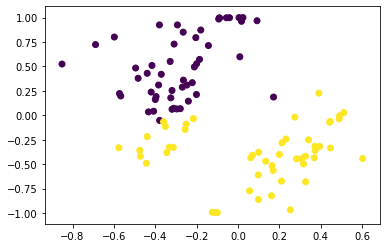

In [127]:
# create a scatter plot
plt.scatter(member_ideology_df_subset.nominate_dim1, 
            member_ideology_df_subset.nominate_dim2, 
            c=clu.labels_)

Previously, I picked 2 clusters mainly because I figured that would make sense given our two party system. But perhaps the political world is more complex, and we may have better performance with a more complex method. Let's run some additional clustering solutions with different values of $k$ and compare their performance.

In [128]:
# create a dictionary to hold the sses
sse = {}

# run the clustering algorithm over different values of k
for k in range(1, 10):
  
  # perform clustering
  clu = KMeans(n_clusters=k, random_state=0).fit(member_ideology_df_subset[["nominate_dim1", "nominate_dim2"]].values)

  # save the sses
  sse[k] = clu.inertia_

Now let's plot the result.

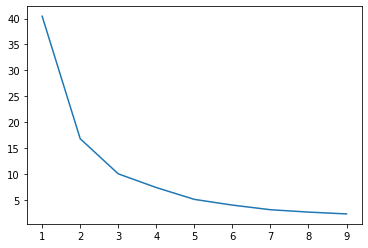

In [129]:
pd.Series(sse).plot()

## Hierarchical clustering

Hierarchical is another common but powerful approach to clustering. The approach is called "hierarchical" because we aggregate or parition observations (more on that in a second) in stages, such that progressively larger (smaller) clusters are aggregated (partitioned), which as you'll see, give us a natural hierarchy of clusters. There are two main approaches to hierarchical clustering. 

  * Agglomerative approaches are bottom up; they start with each observation in its own cluster, and then progressively group clusters together using some notion of similarity. 
  * Divisive approaches are top down; they start with a all observations assigned to a single cluster, and then progressively partition clusters into smaller groups, again based on some notion of similarity.
  
Hierarchical clustering algorithms have a number of attractive features. Unlike k-means, we do not need to provide the algorithm with the number of clusters we want to find in advance. In addition, the hierarchical nature of the clusters produced often maps more closely on to real world problems, where we commonly see examples of nested categories (e.g., a mouse is a subcategory of mamal, which is a subset of animal). 

Hierarchical clustering works by comparing similarities among points. That means that when implementing hierarchical clustering, you'll need to think about what would be an appropriate distance function among your data points. Since our features are two continuous numbers (i.e., the nominate ideology scores), we'll just use Euclidean distances.

The other thing you'll need to think about when performing hierarchical clustering on your data is how to compare the distances among sets of clusters as you build your tree. Specifically, how do you determine which cluster is closest to a focal cluster? In practice, there are a few common methods.

  * ward minimizes the variance of the clusters being merged
  * __Average linkage__ find clusters with the smallest average pairwise distance between points.
  * __Complete linkage__ find clusters with the smallest maximum pairwise distance between points.
  * __Single linkage__ find clusters with the smallest minimum pairwise distance between points.

We'll start out with a little data preparation work. Let's dig in! 

In [180]:
# pull a subset
member_ideology_df_subset = member_ideology_df[member_ideology_df.congress == 115]

# drop congress column
member_ideology_df_subset = member_ideology_df_subset.drop(columns=["congress"])

# check out the data
member_ideology_df_subset.head()

,icpsr,bioname,party_code,nominate_dim1,nominate_dim2
48713,41704,"STRANGE, Luther Johnson, III",200,0.560,0.180
48714,41705,"JONES, Gordon Douglas (Doug)",100,-0.091,0.207
48715,49700,"SESSIONS, Jefferson Beauregard III (Jeff)",200,0.549,0.130
48716,94659,"SHELBY, Richard C.",200,0.428,0.514
48717,40300,"MURKOWSKI, Lisa",200,0.210,-0.290


We're now ready to run our clustering using scikit-learn.

In [181]:
# load some packages
from sklearn.cluster import AgglomerativeClustering

In [182]:
# train our modelb
clu = AgglomerativeClustering(distance_threshold=0, 
                              linkage="complete", 
                              affinity="euclidean",
                              n_clusters=None).fit(member_ideology_df_subset[["nominate_dim1", "nominate_dim2"]].values)

We can visualize our clustering solution using a dendrogram. Turns out it is much easier to plot a dendrogram using `scipy` than it is using `scikit-learn`. For our purposes, `scipy` is just fine, so we'll go that route; that mean's we'll need to redo our clustering using `scipy`. If you want to stick with your clustering solution from `scikit-learn`, there is an example of how to plot a dendrogram in the [documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py).

In [183]:
# load some packages
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

In [184]:
# redo our clustering solution
clu_scipy = linkage(member_ideology_df_subset[["nominate_dim1", "nominate_dim2"]].values, 
                    method="complete", 
                    metric='euclidean')

Now we're ready to actually plot the dendrogram.

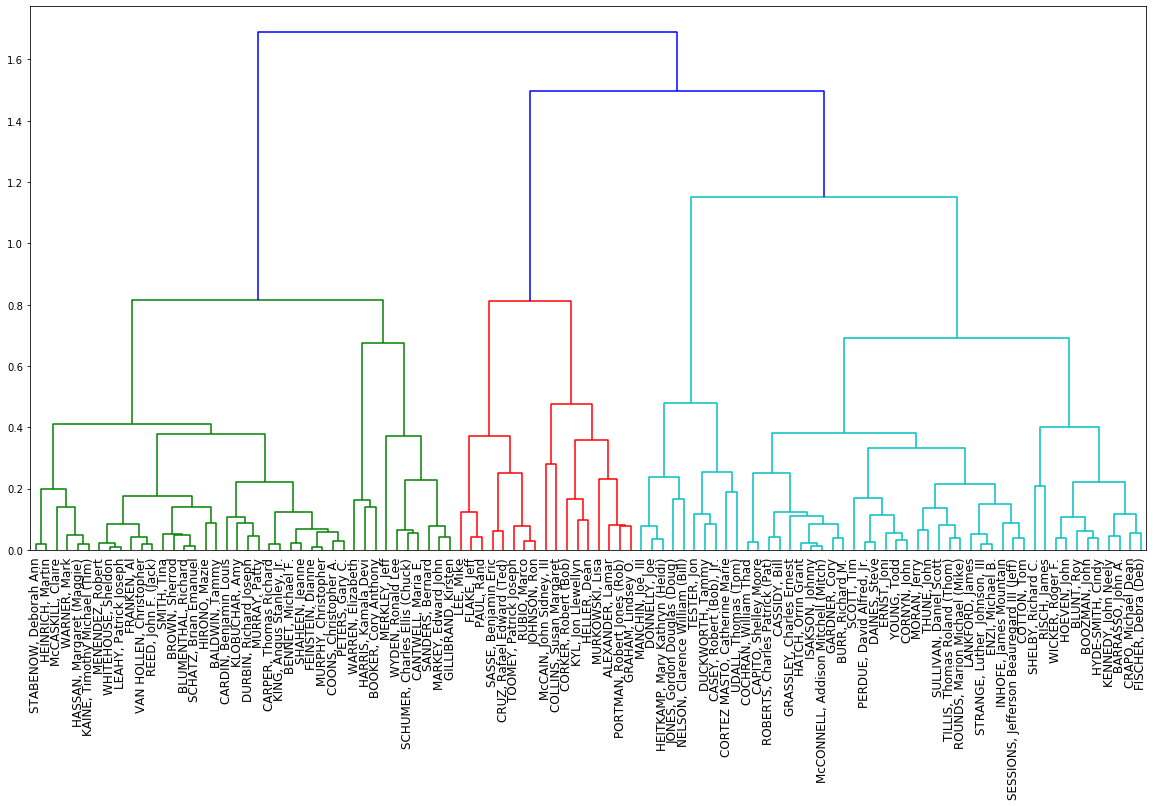

In [196]:
# set the size for the figure
plt.figure(figsize=(20,10))

# plot the dendrogram
dn = dendrogram(clu_scipy, 
                leaf_font_size=12, 
                labels=member_ideology_df_subset["bioname"].values)

Note that in the dendrogram, the y-axis is the value of the distance metric between clusters.

# Further reading

Here are some of the sources I have found helpful.

  * Hastie, Trevor, Robert Tibshirani, and Jerome Friedman (2009) The elements of statistical learning: Data mining, inference, and prediction. New York: Springer.
  * Manning, Christopher D., Prabhakar Raghavan, and Hinrich Schütze. (2008) Introduction to information retrieval. Cambridge: Cambridge University Press.
  * Murphy, Kevin P. (2012) Machine learning: A probabilistic perspective. Camrbidge, MA: MIT Press.

# Exercises

  * Using the unsupervised learning approaches above, repeat the clustering exercise for each distinct congress. How does the number of clusters obtained change over time?
  * Conduct a similar exercise, but for the organizational form data (on patenting). How does the distribution of organizational forms change over time?
  * Repeat the exercises above, but using raw vote data, rather than the ideology scores. There is some code below to help you get started. Note, however, that the methods we've used above typically will require numerical data as input, so you'll need to do something like convert the raw scores to many different 0/1 dummy variables. Hint: look up "one-hot encoding."
  * Revise the hierearchical clustering approach above to use a different linkage method. How do the results change.

# Appendix

## Reshaping raw votes

If you are interested in analyzing raw votes, some of the code below may be helpful.

In [199]:
# pull a subset
member_vote_df_subset = member_vote_df[member_vote_df.congress == 115]

# drop congress column
member_vote_df_subset = member_vote_df_subset.drop(columns=["congress"])

# check out the data
member_vote_df_subset.head()

,icpsr,rollnumber,cast_code
24336451,14009,1,1
24336452,14226,1,1
24336453,14307,1,6
24336454,14435,1,6
24336455,14503,1,1


In [198]:
# convert to wide dataframe
member_vote_df_subset.pivot(index="icpsr", columns="rollnumber", values="cast_code")

rollnumber,1,2,3,4,5,6,7,8,9,10,...,590,591,592,593,594,595,596,597,598,599
icpsr,,,,,,,,,,,,,,,,,,,,,
14009,1,6,6,6,6,6,6,6,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14226,1,6,6,6,6,6,6,6,1,6,...,1,6,1,6,6,6,1,1,1,1
14307,6,1,6,1,6,1,1,1,6,1,...,6,1,1,6,6,6,1,1,1,6
14435,6,1,6,1,6,1,1,1,6,1,...,6,1,1,6,6,6,1,1,1,6
14503,1,6,6,6,6,6,6,6,1,6,...,1,6,1,6,6,6,1,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49700,1,6,6,6,9,9,9,9,9,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49703,1,6,6,1,1,1,6,1,1,1,...,1,1,1,1,6,1,1,1,6,1
49706,1,6,6,6,6,6,6,6,1,6,...,1,6,6,1,1,1,6,1,6,1
